In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

from commpy.modulation import QAMModem, PSKModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.plot import pconst
from optic.models import phaseNoise, coherentReceiver, pdmCoherentReceiver, manakovSSF
from optic.dsp import pulseShape, firFilter, decimate, symbolSync
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power

In [18]:
help(simpleWDMTx)

Help on function simpleWDMTx in module optic.tx:

simpleWDMTx(param)
    Simple WDM transmitter
    
    Generates a complex baseband waveform representing a WDM signal with
    arbitrary number of carriers
    
    :param.M: modulation order [default: 16]
    :param.constType: 'qam' or 'psk' [default: 'qam']
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarizati

In [19]:
# Parâmetros - Transmissor
paramTx = parameters()

paramTx.M   = 16           # Ordem do formato de modulação (QAM)
paramTx.constType = 'qam'  # Formato de modulação ('qam' ou 'psk')
paramTx.SpS = 16           # Número de amostras por símbolo
paramTx.Rs  = 32e9         # Taxa de sinalização [baud]

paramTx.Nbits = 800000     # Número total de bits por polarização

paramTx.pulse    = 'rrc'   # Tipo do filtro formatador de pulso
paramTx.Ntaps    = 1024    # Número de coeficientes do filtro
paramTx.alphaRRC = 0.01    # Rolloff do pulso RRC

paramTx.Pch_dBm  = 0       # Potência média por canal WDM [dBm]
paramTx.Nch      = 1       # Número de canais WDM
paramTx.freqSpac = 40.0e9  # Espaçamento WDM

paramTx.Fc     = 193.1e12  # Frequência central de operação
paramTx.Nmodes = 2         # Número de modos de polarização

print('Parâmetros do Transmissor')
print('- Formato de Modulação: {}-{}' .format(paramTx.M, paramTx.constType.upper()))
print('- Taxa de Sinalização: {} Gbaud' .format(paramTx.Rs*1e-9))
print('- Potência Média Enviada: {} dBm' .format(paramTx.Pch_dBm))
print('- Frequência de Operação: {} THz' .format(paramTx.Fc*1e-12))
print('- Número de polarizações do sinal: {}\n\n' .format(paramTx.Nmodes))

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

Parâmetros do Transmissor
- Formato de Modulação: 16-QAM
- Taxa de Sinalização: 32.0 Gbaud
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 2


channel 0	 fc : 193.1000 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm


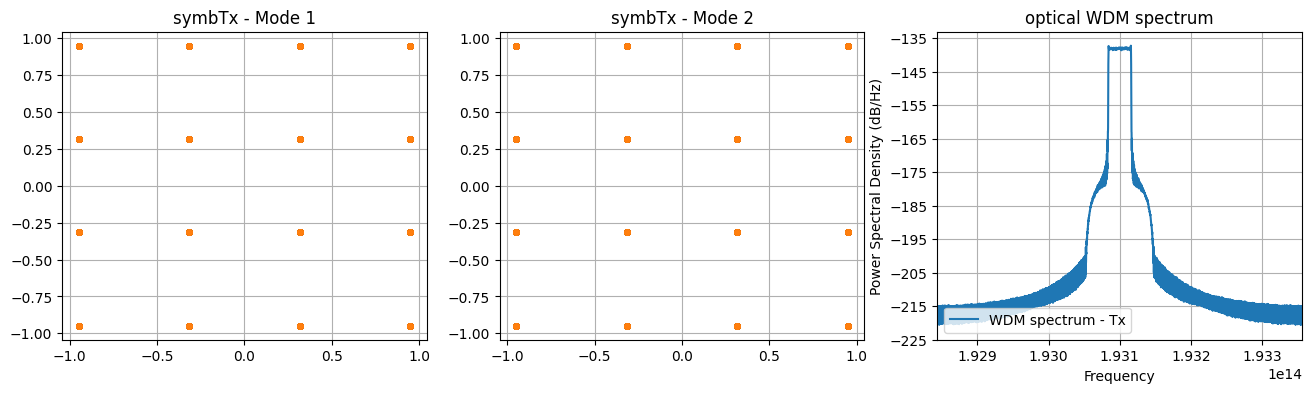

In [20]:
Fs = paramTx.Rs*paramTx.SpS # Taxa de amostragem

# plot psd and constellations
if paramTx.Nmodes == 1:
    fig, axs = plt.subplots(1, 2, figsize=(14,4))

    axs[0].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
    axs[0].set_title('symbTx - Mode 1');
    axs[0].grid('True')
    
    axs[1].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
    axs[1].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2);
    axs[1].legend(loc='lower left')
    axs[1].set_title('optical WDM spectrum');
else:
    fig, axs = plt.subplots(1, 3, figsize=(16,4))

    axs[0].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
    axs[0].set_title('symbTx - Mode 1');
    axs[0].grid('True')
    
    axs[1].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
    axs[1].set_title('symbTx - Mode 2');
    axs[1].grid('True')
    
    axs[2].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
    axs[2].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2);
    axs[2].legend(loc='lower left')
    axs[2].set_title('optical WDM spectrum');

In [21]:
help(manakovSSF)

Help on function manakovSSF in module optic.models:

manakovSSF(Ei, Fs, paramCh)
    Manakov model split-step Fourier (symmetric, dual-pol.)
    
    :param Ei: input signal
    :param Fs: sampling frequency of Ei [Hz]
    :param paramCh: object with physical parameters of the optical channel
    
    :paramCh.Ltotal: total fiber length [km][default: 400 km]
    :paramCh.Lspan: span length [km][default: 80 km]
    :paramCh.hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :paramCh.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :paramCh.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :paramCh.gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :paramCh.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :paramCh.amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :paramCh.NF: edfa noise figure [dB] [default: 4.5 dB]
    
    :return Ech: propagated signal



In [23]:
# Canal Óptico
paramCh = parameters()

paramCh.Ltotal = 0       # total link distance [km]
paramCh.Lspan  = 50      # span length [km]

paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]

paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.1         # step-size of the split-step Fourier method [km]

if not paramCh.Ltotal:
    print('Configuração: back-to-back')
    sigWDM = sigWDM_Tx
else:
    print(f'Enlace de {paramCh.Ltotal:.2f} km')
    # nonlinear signal propagation
    sigWDM, paramCh = manakovSSF(sigWDM_Tx, Fs, paramCh)

Configuração: back-to-back


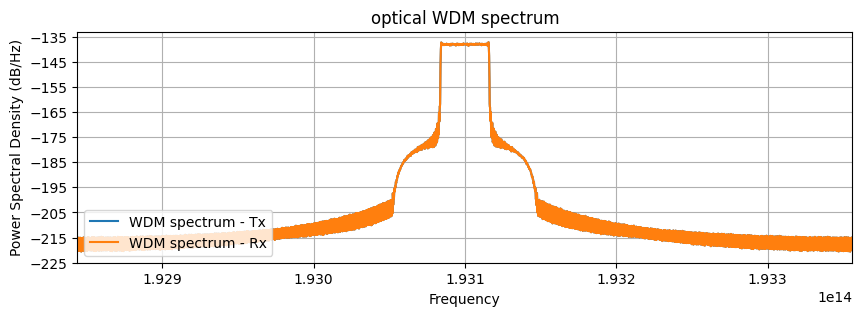

In [25]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

In [26]:
help(coherentReceiver)
print('------------------------------------------------------------')
help(pdmCoherentReceiver)

Help on function coherentReceiver in module optic.models:

coherentReceiver(Es, Elo, Rd=1)
    Single polarization coherent optical front-end
    
    :param Es: input signal field [nparray]
    :param Elo: input LO field [nparray]
    :param Rd: photodiode resposivity [scalar]
    
    :return: downconverted signal after balanced detection

------------------------------------------------------------
Help on function pdmCoherentReceiver in module optic.models:

pdmCoherentReceiver(Es, Elo, θsig=0, Rdx=1, Rdy=1)
    Polarization multiplexed coherent optical front-end
    
    :param Es: input signal field [2d nparray]
    :param Elo: input LO field [nparray]
    :param θsig: polarization rotation angle [rad][default: 0]
    :param Rdx: photodiode resposivity pol.X [scalar]
    :param Rdy: photodiode resposivity pol.Y [scalar]
    
    :return: downconverted signal after balanced detection



Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm

Local oscillator
 - Power: 10.00 dBm
 - LineWidth: 200.00 kHz
 - Frequency offset: 0.00


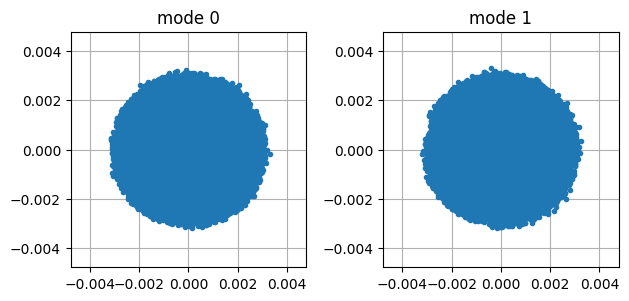

In [40]:
# Receptor Coerente

chIndex  = 0     # index of the channel to be demodulated
plotPSD  = True

Fc = paramTx.Fc #paramCh.Fc
Ts = 1/Fs

if paramTx.constType == 'qam':
      mod = QAMModem(m=paramTx.M)
elif paramTx.constType == 'psk':
      mod = PSKModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 200e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f}')

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
if paramTx.Nmodes == 1:
      sigRx = coherentReceiver(sigWDM, sigLO)
else:
      sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig = π/3, Rdx=1, Rdy=1)

# plot constellations
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

In [41]:
help(edc)

Help on function edc in module optic.equalization:

edc(Ei, L, D, Fc, Fs)
    Electronic chromatic dispersion compensation (EDC)
    
    :param Ei: dispersed signal
    :param L: fiber length [km]
    :param D: chromatic dispersion parameter [ps/nm/km]
    :param Fc: carrier frequency [Hz]
    :param Fs: sampling frequency [Hz]
    
    :return Eo: CD compensated signal



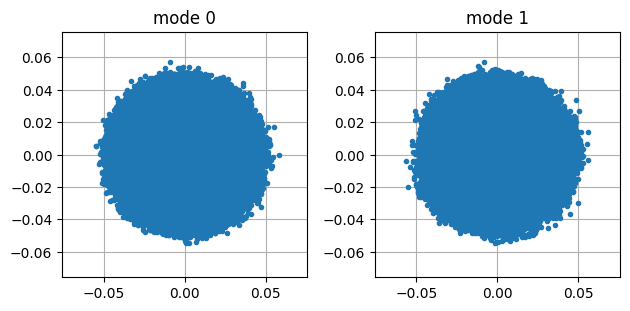

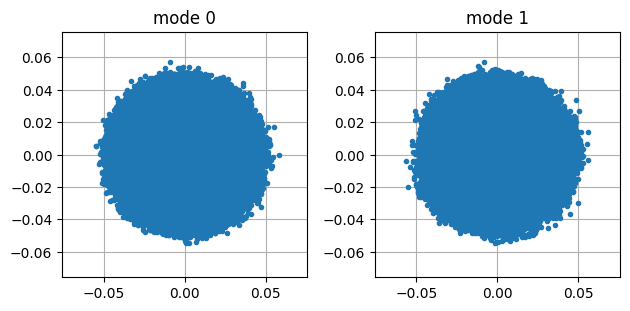

In [42]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

# CD compensation
if paramCh.Ltotal:
    sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)
    
# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

In [43]:
help(decimate)

Help on function decimate in module optic.dsp:

decimate(Ei, param)
    Decimate signal
    
    Parameters
    ----------
    Ei : ndarray
        Input signal.
    param : core.parameter
        Decimation parameters:            
            param.SpS_in  : samples per symbol of the input signal.
            param.SpS_out : samples per symbol of the output signal.
    
    Returns
    -------
    Eo : ndarray
        Decimated signal.



In [44]:
# decimation
paramDec = parameters()

paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2

sigRx = decimate(sigRx, paramDec)
symbRx = symbolSync(sigRx, symbTx, 2)

In [45]:
x = sigRx
d = symbRx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

In [46]:
help(mimoAdaptEqualizer)

Help on function mimoAdaptEqualizer in module optic.equalization:

mimoAdaptEqualizer(x, dx=[], paramEq=[])
    N-by-N MIMO adaptive equalizer





da-rde - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

da-rde pre-convergence training iteration #0
da-rde MSE = 0.006593.
da-rde pre-convergence training iteration #1
da-rde MSE = 0.004383.
da-rde pre-convergence training iteration #2
da-rde MSE = 0.004344.
da-rde pre-convergence training iteration #3
da-rde MSE = 0.004317.
da-rde pre-convergence training iteration #4
da-rde MSE = 0.004298.


rde - training stage #1
rde MSE = 0.003751.


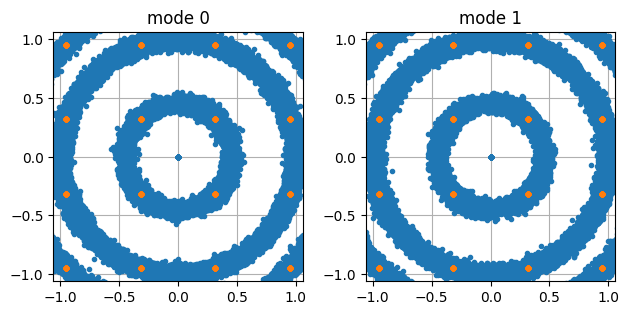

In [47]:
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['da-rde','rde']
paramEq.M     = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

#plot constellations after adaptive equalization
discard = 5000
pconst([y_EQ[discard:-discard,:], d], lim=True)

In [48]:
help(cpr)

Help on function cpr in module optic.carrierRecovery:

cpr(Ei, symbTx=[], paramCPR=[])
    Carrier phase recovery function (CPR)
    
    Parameters
    ----------
    Ei : complex-valued ndarray
        received constellation symbols.
    symbTx :complex-valued ndarray, optional
        Transmitted symbol sequence. The default is [].
    paramCPR : core.param object, optional
        configuration parameters. The default is [].
        
        BPS params:
            
        paramCPR.alg: CPR algorithm to be used ['bps' or 'ddpll']
        paramCPR.M: constellation order. The default is 4.
        paramCPR.N: length of BPS the moving average window. The default is 35.    
        paramCPR.B: number of BPS test phases. The default is 64.
        
        DDPLL params:
            
        paramCPR.tau1: DDPLL loop filter param. 1. The default is 1/2*pi*10e6.
        paramCPR.tau2: DDPLL loop filter param. 2. The default is 1/2*pi*10e6.
        paramCPR.Kv: DDPLL loop filter gain. The

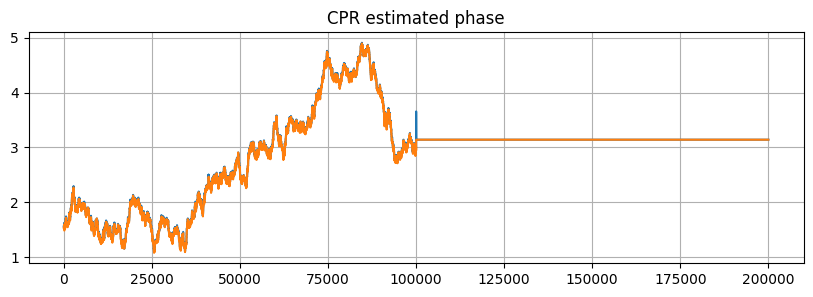

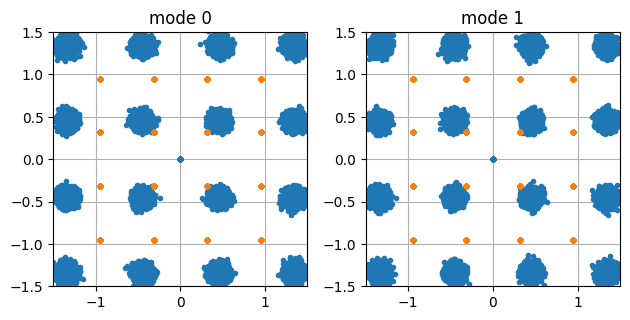

In [55]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 35
paramCPR.B   = 128
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
#plt.xlim(0, len(θ))
plt.grid();

discard = 5000

#plot constellations after CPR
pconst([y_CPR[discard:-discard,:], d], lim=True)

In [56]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

C:\Users\Felipe\AppData\Local\Temp\ipykernel_7560\78919923.py:3: RuntimeWarning: divide by zero encountered in divide
  rot = np.mean(d[:,k]/y_CPR[:,k])
D:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Felipe\AppData\Local\Temp\ipykernel_7560\78919923.py:6: RuntimeWarning: invalid value encountered in divide
  y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))
D:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\opticcommpy-0.1.0-py3.9.egg\optic\metrics.py:82: RuntimeWarning: invalid value encountered in divide
D:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\opticcommpy-0.1.0-py3.9.egg\optic\metrics.py:86: RuntimeWarning: invalid value encountered in divide
D:\Users\Felipe\Desktop\Workspace\TCC-SER\venv_tcc\lib\site-packages\opticcommpy-0.1.0-py3.9.egg\optic\metrics.py:169: RuntimeWarning:

     pol.X     pol.Y      
SER: 9.38e-01, 9.37e-01
BER: 5.01e-01, 5.00e-01
SNR: nan dB, nan dB
MI: nan bits, nan bits
GMI: nan bits, nan bits
